In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

In [7]:
import os 

dir_path = '/kaggle/input/uppercase-chars/dataset/train'
total = 0

for subdir in os.listdir(dir_path):
    subdir_path = f'{dir_path}/{subdir}'

    for img_path in os.listdir(subdir_path):
        total += 1


print(f'we have {total} images in the split')

we have 182465 images in the split


In [11]:
import numpy as np
import cv2
import os

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255) # No augmentation for validation
test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for test


# Train
train_it = train_datagen.flow_from_directory(
    '/kaggle/input/uppercase-chars/dataset/train',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)


# Validation
val_it = val_datagen.flow_from_directory(
    '/kaggle/input/uppercase-chars/dataset/val',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size
)


# Test
test_it = test_datagen.flow_from_directory(
    '/kaggle/input/uppercase-chars/dataset/test',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 182465 images belonging to 26 classes.
Found 22755 images belonging to 26 classes.
Found 22880 images belonging to 26 classes.


In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(128, 128, 1)),
    Conv2D(32, (3,3), activation='relu', padding='same',
          kernel_regularizer=l2(1e-4)),

    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Conv2D(64, (3,3), activation='relu', padding='same',
          kernel_regularizer=l2(1e-4)),

    BatchNormalization(),
    SpatialDropout2D(0.3),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same',
          kernel_regularizer=l2(1e-4)),

    BatchNormalization(),
    GlobalAveragePooling2D(),

    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),

    Dropout(0.5),
    Dense(26, activation='softmax')
])

In [14]:
# import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Update callbacks
earlystop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr * 1.5
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)


model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d (SpatialDropout2D) │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,298 (524.60 KB)

 Trainable params: 133,338 (520.85 KB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
import warnings
warnings.filterwarnings('ignore')

model.fit(
    train_it, validation_data=val_it,
    epochs=20,
    callbacks=[earlystop, reduce_lr]
)

Epoch 1/20
5703/5703 ━━━━━━━━━━━━━━━━━━━━ 946s 164ms/step - accuracy: 0.1408 - loss: 3.3760 - val_accuracy: 0.4921 - val_loss: 1.6022 - learning_rate: 1.0000e-04
Epoch 2/20
5703/5703 ━━━━━━━━━━━━━━━━━━━━ 566s 99ms/step - accuracy: 0.4177 - loss: 1.8974 - val_accuracy: 0.6496 - val_loss: 1.1459 - learning_rate: 1.0000e-04
Epoch 3/20
5703/5703 ━━━━━━━━━━━━━━━━━━━━ 544s 95ms/step - accuracy: 0.5420 - loss: 1.5145 - val_accuracy: 0.6777 - val_loss: 1.0419 - learning_rate: 1.0000e-04
Epoch 4/20
5703/5703 ━━━━━━━━━━━━━━━━━━━━ 521s 91ms/step - accuracy: 0.6092 - loss: 1.3088 - val_accuracy: 0.7165 - val_loss: 0.9197 - learning_rate: 1.0000e-04
Epoch 5/20
5703/5703 ━━━━━━━━━━━━━━━━━━━━ 466s 82ms/step - accuracy: 0.6453 - loss: 1.2002 - val_accuracy: 0.7813 - val_loss: 0.7441 - learning_rate: 1.0000e-04
Epoch 6/20
5703/5703 ━━━━━━━━━━━━━━━━━━━━ 487s 85ms/step - accuracy: 0.6715 - loss: 1.1172 - val_accuracy: 0.8054 - val_loss: 0.6916 - learning_rate: 1.0000e-04
Epoch 7/20
5703/5703 ━━━━━━━━━━━━

In [23]:
model.save('/kaggle/working/CharNet_UCv1.keras')

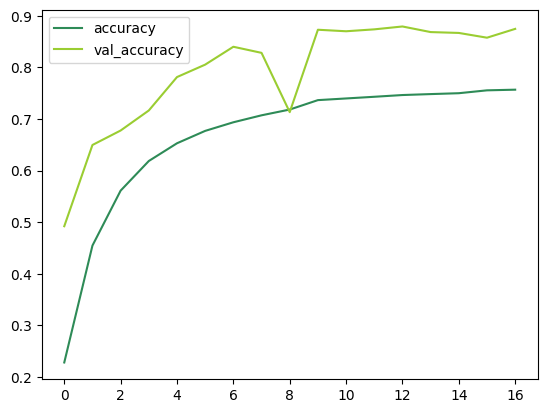

In [18]:
# plot history
import matplotlib.pyplot as plt

plt.plot(model.history.history['accuracy'], label='accuracy', color='seagreen')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy', color='yellowgreen')

plt.legend()
plt.show()

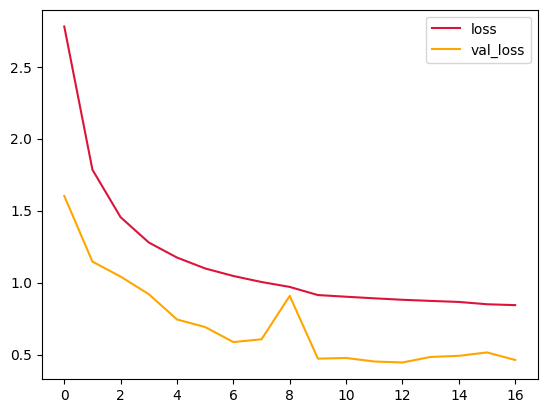

In [19]:
# plot loss

plt.plot(model.history.history['loss'], label='loss', color='crimson')
plt.plot(model.history.history['val_loss'], label='val_loss', color='orange')

plt.legend()
plt.show()


In [20]:
test_loss, test_accuracy = model.evaluate(test_it)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

715/715 ━━━━━━━━━━━━━━━━━━━━ 132s 184ms/step - accuracy: 0.8155 - loss: 0.6975
Test Accuracy: 0.8293, Test Loss: 0.6407


715/715 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step


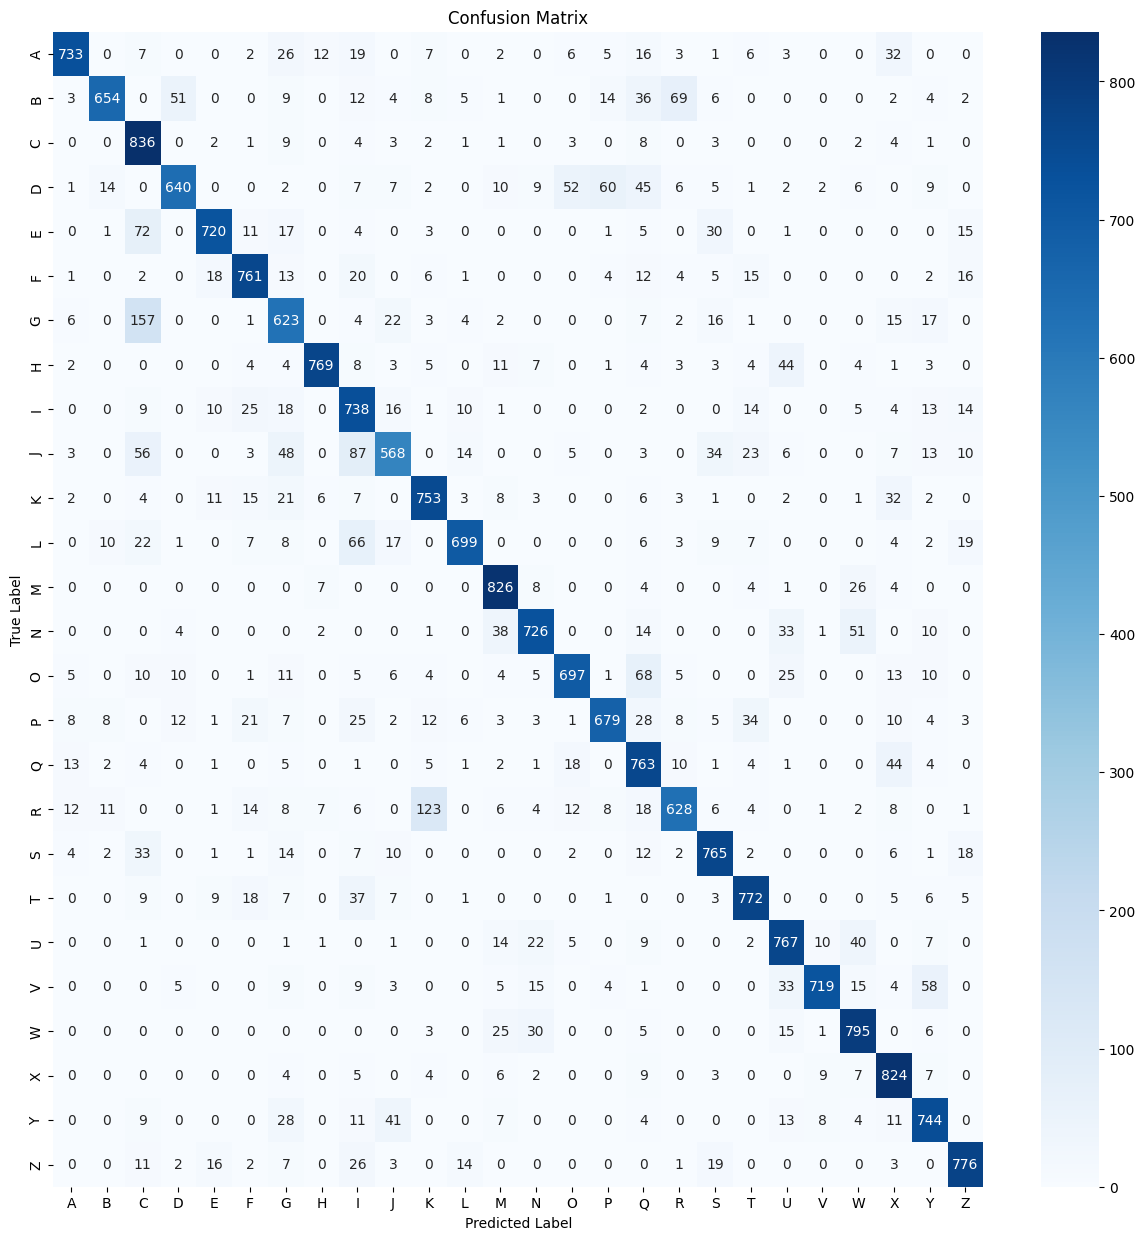


Classification Report:

              precision    recall  f1-score   support

           A       0.92      0.83      0.88       880
           B       0.93      0.74      0.83       880
           C       0.67      0.95      0.79       880
           D       0.88      0.73      0.80       880
           E       0.91      0.82      0.86       880
           F       0.86      0.86      0.86       880
           G       0.69      0.71      0.70       880
           H       0.96      0.87      0.91       880
           I       0.67      0.84      0.74       880
           J       0.80      0.65      0.71       880
           K       0.80      0.86      0.83       880
           L       0.92      0.79      0.85       880
           M       0.85      0.94      0.89       880
           N       0.87      0.82      0.85       880
           O       0.87      0.79      0.83       880
           P       0.87      0.77      0.82       880
           Q       0.70      0.87      0.78       880
  

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels
true_labels = test_it.classes

# Get predicted probabilities
pred_probs = model.predict(test_it)

# Convert predicted probabilities to class labels
pred_labels = np.argmax(pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_it.class_indices, yticklabels=test_it.class_indices)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=test_it.class_indices.keys()))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


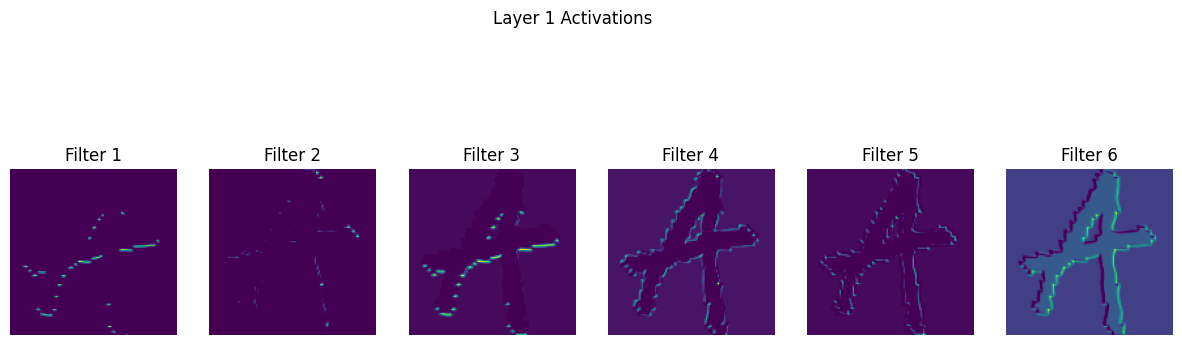

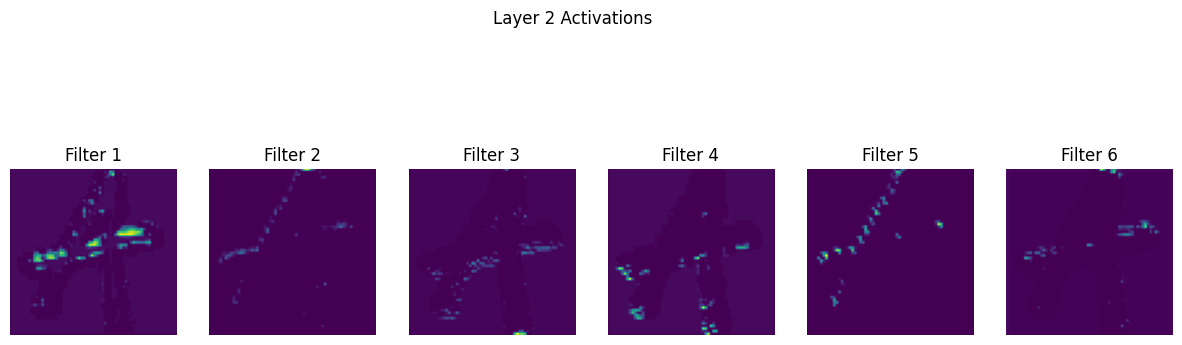

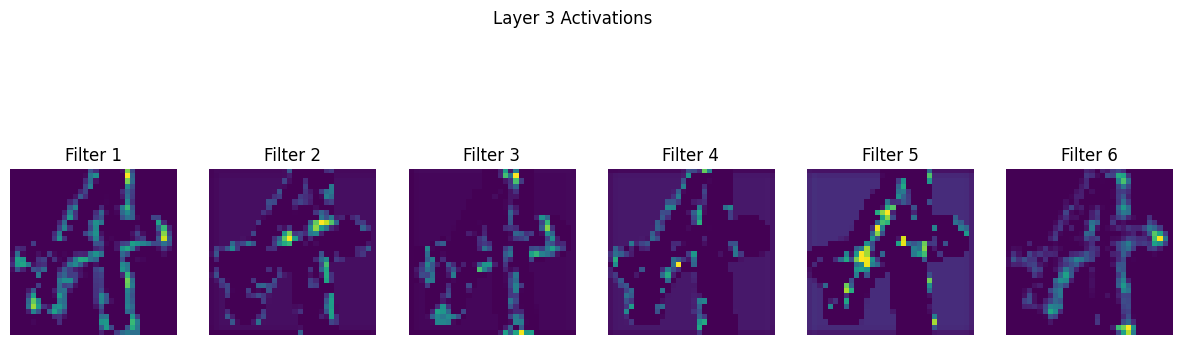

In [26]:
from tensorflow.keras.models import Model
import numpy as np


if not model.built:
    model.build(input_shape=(None, 128, 128, 1))

# Ensure the model is built and called at least once
dummy_input = np.zeros((1, 128, 128, 1))
_ = model.predict(dummy_input)

# Extract convolutional layer outputs
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = Model(inputs=model.layers[0].input, outputs=layer_outputs)


# One test image
img = test_it[0][0][20]
img = np.expand_dims(img, axis=0)

# Get feature maps
activations = activation_model.predict(img)

for i, activation in enumerate(activations):
    num_filters = activation.shape[-1]
    fig, axes = plt.subplots(1, min(num_filters, 6), figsize=(15, 5))

    for j in range(min(num_filters, 6)):
        axes[j].imshow(activation[0, :, :, j], cmap="viridis")
        axes[j].axis("off")
        axes[j].set_title(f"Filter {j+1}")

    plt.suptitle(f"Layer {i+1} Activations")
    plt.show()